<a href="https://colab.research.google.com/github/chhyyi/aiffel/blob/main/datathon/%EC%A0%9C%EC%B6%9C%EC%9A%A9_%ED%86%B5%ED%95%A9_%EB%85%B8%ED%8A%B8%EB%B6%81_%EC%B9%B4%ED%94%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 카드소비 패턴 분석 - SHINHAN ROSY팀 
__이창현 개인 깃허브 업로드용__  
이창현
깃허브: https://github.com/chhyyi/aiffel

## 1.1. 데이터 개요
서울특별시 데이터 캠퍼스에서 
> 국내 전 지역 가맹점을 대상으로 서울시민의 개인카드(신용카드, 체크카드. 법인카드 제외) 사용 패턴 집계.  

[서울특별시 빅데이터 캠퍼스](https://bigdata.seoul.go.kr/data/selectSampleData.do?r_id=P213&sample_data_seq=318&tab_type=&file_id=&sch_text=%EC%84%9C%EC%9A%B8%EC%8B%9C%EB%AF%BC%EC%9D%98+%EC%97%85%EC%A2%85%EB%B3%84&sch_order=U&currentPage=1) 에서 자료에 대한 정보 등을 확인할 수 있다. 하지만 내용 파악에 어려움이 많았다. 4개의 데이터에 나뉜 데이터들은 서로 별 관련 없이 대부분 별개의 것이었고, 집계구에 대한 정보를 참고했다는 파일은 그 설명이 충분하지 않았다.


## 구글 드라이브 마운트:


In [ ]:
#some codes for mount drive in google
from google.colab import drive
drive.mount('/content/drive')
from collections import OrderedDict

BASE_DIR = r'/content/drive/MyDrive/_aiffel/_datathon_rosy/CrdCnsmptn/csv/' #directory of csv files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 글꼴 설치 (피규어 한글 출력)
실행 후 런타임->런타임 다시 시작 필요

In [ ]:
#restart runtime after installation
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

## 데이터 및 각종 패키지(라이브러리) 불러오기
가장 많이 수정된 부분일 것이다.
- 3명이 같이 작업하는데 공통적으로 어떤 변수를 쓰고 fork된 버전들을 어떻게 관리할지 잘 알지 못했다. 결국 하다보니 자연스럽게 하나를 따라 쓰기로 했다.  
- 5개의 csv파일이 있는데 '카드소비 업종코드.csv'는 나머지 세 개의 csv에 column으로 들어있는 업종코드나 '집계구별 일별시간대별 카드소비패턴.csv'에 들어있는 대분류가 어떤 것인지 아는데 필요한 파일이다. 
- 하지만 '고객주소블록코드'나 '고객주소집계구별' 같은 column은 그런 파일이 없다. 전자의 경우 거주자가 50명 정도일 정도로 작은 구역으로 나눈 것이라 개인정보 보호 때문에 공개되지 않는 것 같다. 후자의 경우는 찾아볼 수 있지만 해마다 조금씩 달라지는 등 문제가 있다. 이 column들은 결국 사용하지 않았다. 고객주소를 구 단위로만 보아도 많은 데이터를 추출할 수 있었을텐데 아쉽다.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse
import seaborn as sns
sns.set(font_scale=1.5)

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.titlepad']=20
from math import pi
import warnings
warnings.filterwarnings("ignore")

other_color = "salmon"
korea_color = "skyblue"

BASE_DIR = r'/content/drive/MyDrive/_aiffel/_datathon_rosy/CrdCnsmptn/csv/'


block_time_card = pd.read_csv(BASE_DIR+'블록별 시간대별소액결제건수 카드소비패턴.csv', encoding = 'cp949')
block_time_card.rename(columns = {'서울시민업종코드(UPJONG_CD)' : 'upjoing_cd', '기준년월(YM)' : 'ym',
                                  '시간대구간(TIME)' : 'time', '고객주소블록코드(BLOCK_CD)' : 'block_cd',
                                  '소액결제건수(MICRO_PYM)' : 'micro_pym', '카드이용금액계(AMT_CORR)' : 'amt_corr'}, inplace = True)

card_use_pattern = pd.read_csv(BASE_DIR+'블록별 성별연령대별 카드소비패턴.csv', encoding='cp949')
card_use_pattern.rename(columns={'서울시민업종코드(UPJONG_CD)' : 'upjoing_cd', '기준년월(YM)' : 'ym' , 
                         '고객주소블록코드(BLOCK_CD)' : 'block_cd', '성별(GEDNER)' : 'gender',
                        '연령대별(AGE)' : 'age', '카드이용금액계(AMT_CORR)' : 'amt_corr',
                         '카드이용건수계(USECT_CORR)' : 'usect_corr'}, inplace = True)
card_use_pattern['Sex'] = card_use_pattern['gender'] == 'M'

card_use_code = pd.read_csv(BASE_DIR+'카드소비 업종코드.csv', encoding='cp949')
card_use_code.rename(columns={'업종코드(UPJONG_CD)' : 'upjoing_cd', '대분류(CLASS1)' : 'class1' , 
                         '중분류(CLASS2)' : 'class2', '소분류(CLASS3)' : 'class3'}, inplace = True)

agg_card_where = pd.read_csv(BASE_DIR+'집계구별 일별소비지역별 카드소비패턴.csv' , encoding='cp949')
agg_card_where.rename(columns= {'가맹점주소광역시도(SIDO)' : 'sido', '가맹점주소시군구(SGG)' : 'sgg', 
                                '업종대분류(UPJONG_CLASS1)' : 'class1', '기준일자(YMD)' : 'ymd',
                               '고객주소집계구별(TOT_REG_CD)' : 'tot_reg_cd', '카드이용금액계(AMT_CORR)' : 'amt_corr',
                               '카드이용건수계(USECT_CORR)' : 'usect_corr'}, inplace = True)

agg_card_time = pd.read_csv(BASE_DIR+'집계구별 일별시간대별 카드소비패턴.csv', encoding = 'cp949')
agg_card_time.rename(columns={'업종대분류(UPJONG_CLASS1)': 'class1', '기준일자(YMD)' : 'ymd',
                              '시간대구간(TIME)' : 'time', '고객주소집계구별(TOT_REG_CD)' : 'tot_reg_cd',
                             '카드이용금액계(AMT_CORR)' : 'amt_corr', '카드이용건수계(USECT_CORR)' : 'usect_corr'}, inplace = True)

# 2. 결측치 체크
내가 처리한 부분이 딱히 없다.

# 3. 데이터 전처리 및 시각화
## 3.1. 성별/연령대별 소비 패턴
### 성별/연령대별 자료수
500개의 자료를 가지고 파악하는게 쉽지 않다. 연령대와 성별로 나누어 보면 자료의 수가 그렇게 많지 않다는 것을 확인할 수 있다.
- 다양한 코드를 참고하여 노트북을 작성하였고, 그 중 다수는 이 데이터셋을 이용해 경진대회를 연 Dacon의 공유 코드였다. 

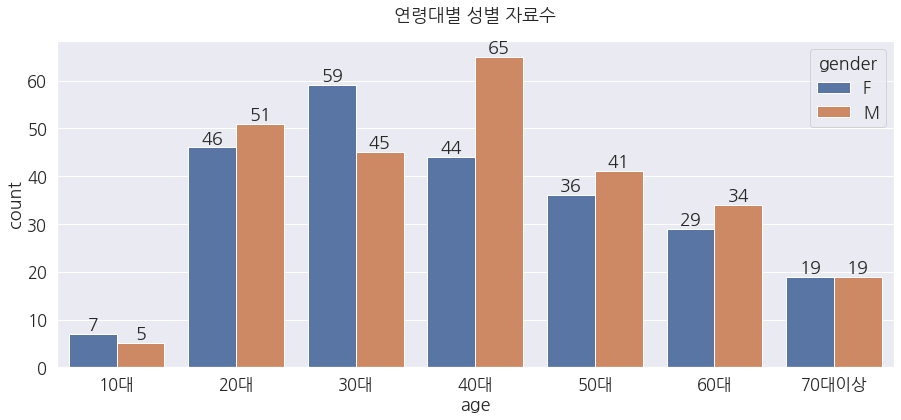

In [ ]:
data=card_use_pattern.copy() #임시로 데이터프레임을 복사하는 경우 copy()를 거쳐 가져가야 원래 데이터의 수정을 막을 수 있습니다.

fig = plt.figure(figsize=(15,6))
plt.title('연령대별 성별 자료수')
bar2=sns.countplot(x ='age',hue='gender',data=data, order=[ '10대','20대','30대','40대','50대','60대','70대이상'])
for p in bar2.patches: #annotation(막대별 수치)를 막대 위에 표시합니다.
    bar2.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2.0, p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

 ## 성별에 따른 건수, 금액
 이 데이터의 문제는 또 있는데, 파일별 500개의 데이터가 어떻게 샘플링 된 것인지 전혀 밝히지 않았다는 것이다. 물론 그걸 밝힌다고 해도 두 개의 조건만 걸어도 자료 수가 너무 적어져서 어떤 이야기를 하기는 힘들다.

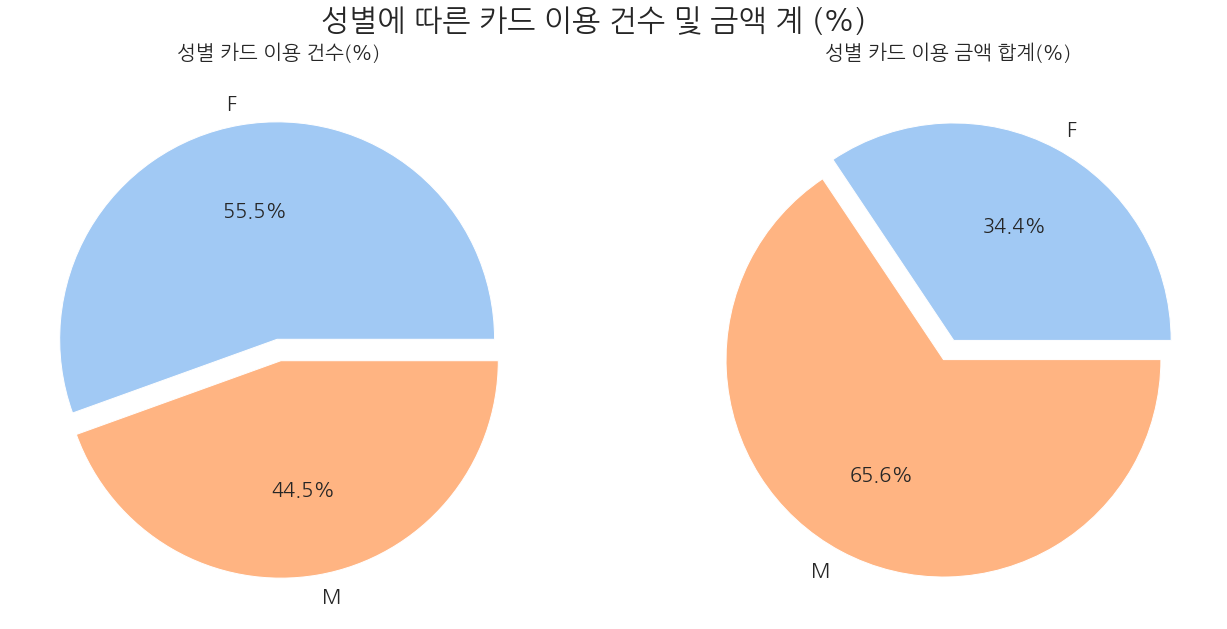

In [ ]:
color = sns.color_palette('pastel')[:10]


a = data.groupby("gender")["usect_corr"].sum()
b= data.groupby("gender")["amt_corr"].sum()
c= data.groupby("gender")["amt_corr"].mean()


plt.figure(figsize = (22, 10))

plt.subplot(1,2,1)
plt.title("성별 카드 이용 건수(%)", fontsize=20)

a.plot(kind = 'pie',explode = [0.05, 0.05], autopct='%1.1f%%',textprops= {'fontsize' : 20},colors = color)
plt.ylabel('',fontsize=20)


plt.subplot(1,2,2)
plt.title("성별 카드 이용 금액 합계(%)", fontsize=20)

b.plot(kind = 'pie',explode = [0.05, 0.05], autopct='%1.1f%%',textprops= {'fontsize' : 20},colors = color)
plt.ylabel('',fontsize=20)



#plt.subplot(1,3,3)
#plt.title("성별 카드 이용 금액 평균", fontsize=20)
#c.plot(kind = 'pie',explode = [0.05, 0.05], autopct='%1.1f',textprops= {'fontsize' : 20},colors = color)
plt.ylabel('',fontsize=20)


plt.suptitle('성별에 따른 카드 이용 건수 및 금액 계 (%)', fontsize = 30)
plt.show()

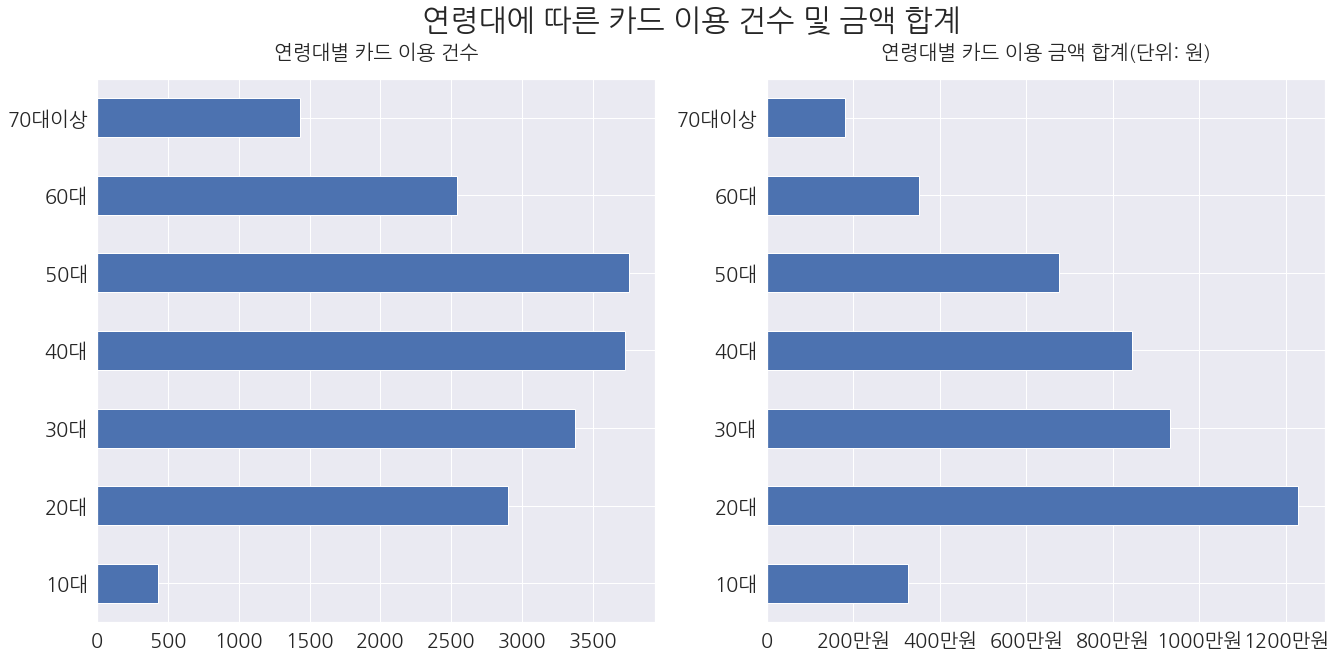

In [ ]:
#fig = plt.figure(figsize=(15,6))
#plt.title('연령대별 자료 분포')

#a = data.groupby("age")["usect_corr"].sum().barh(hue='gender')
b= data.groupby("age")["amt_corr"].sum()
a=data.groupby("age")["usect_corr"].sum()
plt.figure(figsize = (22, 10))

plt.subplot(1,2,1)

plt.title("연령대별 카드 이용 건수", fontsize=20)
a.plot(kind = 'barh')
plt.yticks(fontsize=20)
plt.ylabel('',fontsize=20)
plt.xticks(fontsize=20)

plt.subplot(1,2,2)
plt.title("연령대별 카드 이용 금액 합계(단위: 원)", fontsize=20)
plt.xticks(ticks=[0,2e7,4e7,6e7,8e7,1e8,1.2e8],labels=[0,'200만원','400만원','600만원','800만원','1000만원','1200만원'])
#plt.xticklabels([0,'2백만원','4백만원','6백만원','8백만원','천만원','천이백만원'])
b.plot(kind = 'barh')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('',fontsize=20)

plt.suptitle('연령대에 따른 카드 이용 건수 및 금액 합계', fontsize = 30)
plt.show()

단위, 축의 표시값 같은 것을 이렇게 자세히 바꿔본 것은 처음이었다. 결국 마음에 들지 않아 이용 금액 합계의 경우 string을 직접 입력했다.

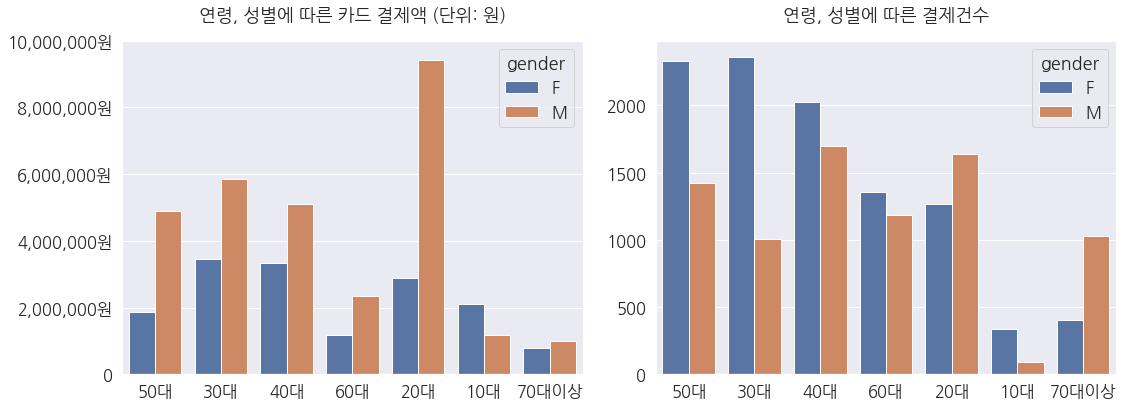

In [ ]:
#성별 - 연령대별 소비 금액/결제 건수
fig, ax=plt.subplots(1,2,figsize=(16,6))

sns.barplot(x = 'age', y = 'amt_corr', hue="gender", data=data, estimator=np.sum, ci=None, ax=ax[0])
#barplot에서 estimator는 평균이지만 여기서는 sum을 구하기 위해 썼습니다. ci=None은 errorbar를 끄기 위해 넣었습니다.
sns.barplot(x = 'age', y = 'usect_corr', hue="gender", data=data, estimator=np.sum, ci=None, ax=ax[1])

ax[0].set_yticks([0,2e7,4e7,6e7,8e7,1e8])
ax[0].set_yticklabels([0,'2,000,000원','4,000,000원','6,000,000원','8,000,000원','10,000,000원'])
ax[0].set_title('연령, 성별에 따른 카드 결제액 (단위: 원)')
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_title('연령, 성별에 따른 결제건수')
plt.tight_layout()
plt.show()

### 업종 - 연령 분석 (heatmap)
merge() method를 이용, data23 이라는 이름으로 임시로 데이터를 합쳐줍니다.
card_use_code에 저장돼있는 업종 코드만 소문자로 돼있고 다른 파일에서는 모두 대문자로 돼있기 때문에 이를 대문자로 고쳐주는 함수를 사용합니다.

__merge()__ method가 있어서 복잡한 작업을 쉽게 끝낼 수 있었다.

In [ ]:

def change_UPJONG_CD(x):
  return  str(x[:2].upper())+str(x[2:])
data_dummy=card_use_code.copy()
data_dummy['upjoing_cd'] = card_use_code['upjoing_cd'].map(change_UPJONG_CD)

data23 = pd.merge(card_use_pattern,data_dummy,left_on='upjoing_cd',right_on='upjoing_cd') 
print(data23.head())


  upjoing_cd      ym  block_cd gender  age  amt_corr  usect_corr    Sex  \
0      SS013  201906     14037      F  50대     48288          65  False   
1      SS013  201710    282738      F  40대   2663385          10  False   
2      SS013  202005     24909      F  20대    960730         101  False   
3      SS013  202012    358999      M  40대    566831           5   True   
4      SS013  201602    216302      M  20대    422520          10   True   

  class1    class2    class3  
0     유통  할인점/슈퍼마켓  할인점/슈퍼마켓  
1     유통  할인점/슈퍼마켓  할인점/슈퍼마켓  
2     유통  할인점/슈퍼마켓  할인점/슈퍼마켓  
3     유통  할인점/슈퍼마켓  할인점/슈퍼마켓  
4     유통  할인점/슈퍼마켓  할인점/슈퍼마켓  


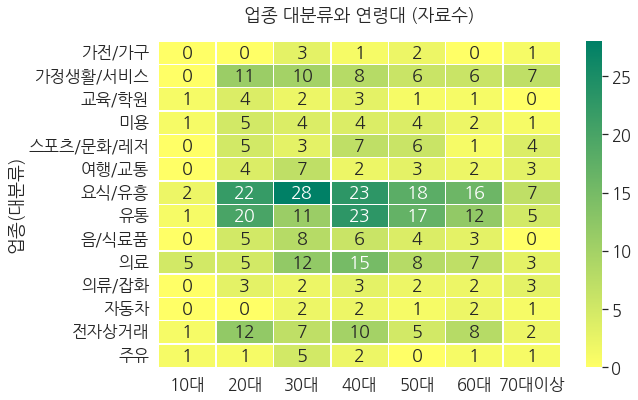

In [ ]:
fig = plt.figure(figsize=(9,6))
a =pd.crosstab(data23['class1'],data23['age'])
sns.heatmap(a,annot = True ,linewidth=.4,cmap='summer_r')
plt.ylabel('업종(대분류)')
plt.xlabel("")
plt.title('업종 대분류와 연령대 (자료수)')
plt.show()

### heatmap의 annotation data 포맷
다음과 같이 heatmap()에서 annot, fmt등의 매개변수값을 줘서 scientific notation (10e7이런 것)을 그냥 정수형으로 바꿔줍니다.

```python
sns.heatmap(pd.crosstab(...), annot=True, fmt="d")
```
그런데 crosstab(...)이 float 타입이라고 안되어서 실제로는 pd.crosstab(...)을 저장하고(pd.DataFrame), 이것의 NaN 값을 0으로 채우고 type을 int로 바꿔준 후에 heatmap에 넣었습니다.

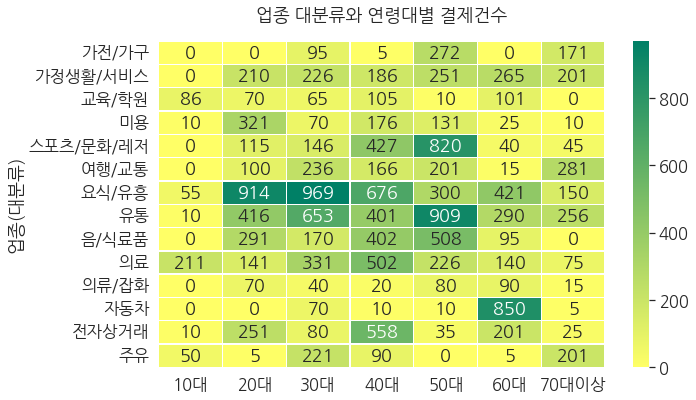

In [ ]:
fig = plt.figure(figsize=(10,6))
a =pd.crosstab(data23['class1'],data23['age'],values=data23['usect_corr'],aggfunc=np.sum)
a.fillna(0.0,inplace=True)
a=a.astype(np.int)

sns.heatmap(a,annot = True, fmt="d" ,linewidth=.4,cmap='summer_r')
plt.ylabel('업종(대분류)')
plt.xlabel("")
plt.title('업종 대분류와 연령대별 결제건수')
plt.show()

## 3.2 지역별 소비 패턴
이 부분도 내가 한 것이 별로 없다.

### 서울시 업종별 카드이용 금액/건수 계
심각한 데이터 문제가 발견됐던 부분이다. 데이터의 신뢰도에서 상당히 의심스러운 부분이 많았다. 강남구의 자동차 항목에 대해 특히 많이 논의되었다. 

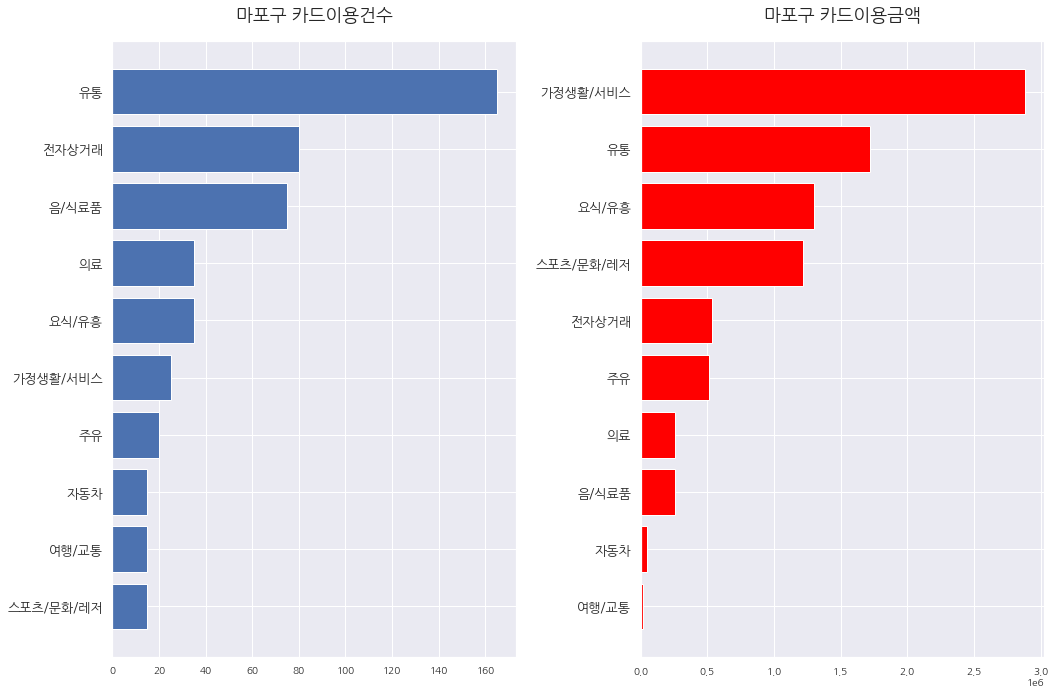

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(1,2,1)
t = agg_card_where[( agg_card_where['sido'] == '서울') & (agg_card_where['sgg'] == '마포구')].groupby(by= 'class1').sum()['usect_corr'].sort_values()
plt.title('마포구 카드이용건수')
plt.barh(t.index,t)


plt.subplot(1,2,2)
t2 = agg_card_where[( agg_card_where['sido'] == '서울') & (agg_card_where['sgg'] == '마포구')].groupby(by= 'class1').sum()['amt_corr'].sort_values()
plt.title('마포구 카드이용금액')
plt.barh(t2.index,t2,color='red')
plt.tight_layout()
plt.show()

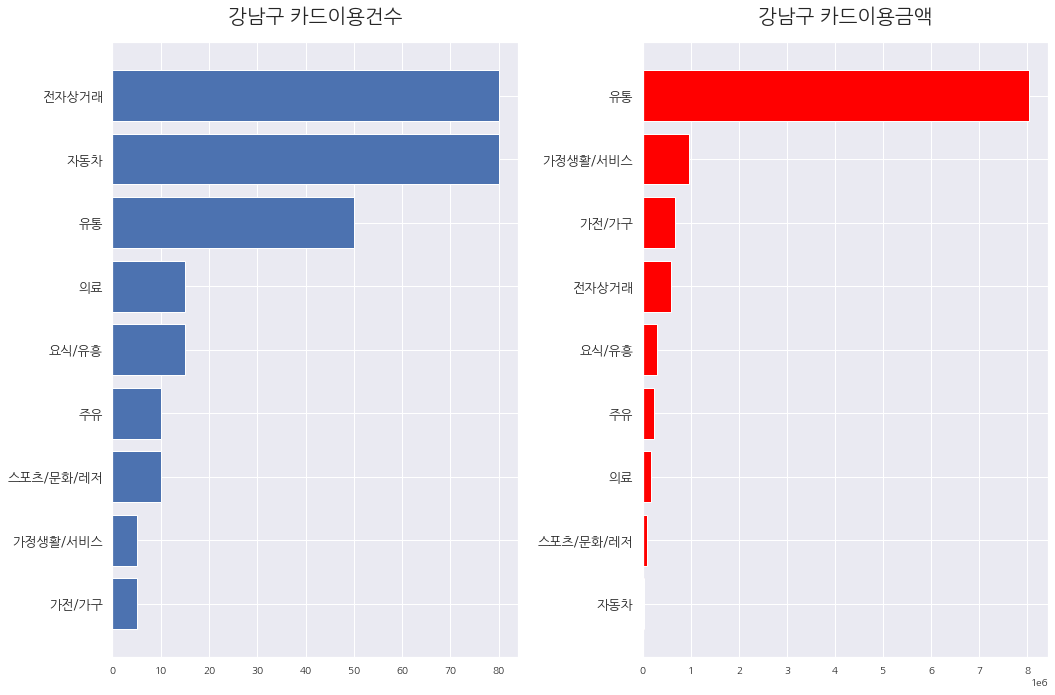

In [ ]:
plt.figure(figsize = (15,10))

plt.subplot(1,2,1)
t = agg_card_where[( agg_card_where['sido'] == '서울') & (agg_card_where['sgg'] == '강남구')].groupby(by= 'class1').sum()['usect_corr'].sort_values()
plt.title('강남구 카드이용건수',fontsize=20)
plt.barh(t.index,t)


plt.subplot(1,2,2)
t2 = agg_card_where[( agg_card_where['sido'] == '서울') & (agg_card_where['sgg'] == '강남구')].groupby(by= 'class1').sum()['amt_corr'].sort_values()
plt.title('강남구 카드이용금액',fontsize=20)
plt.barh(t2.index,t2,color='red')
plt.tight_layout()
plt.show()

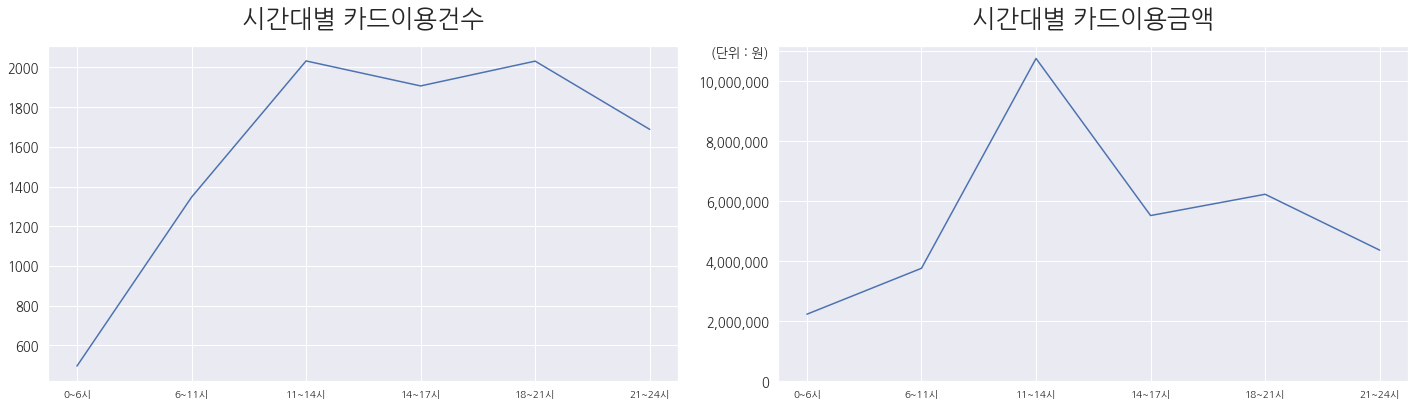

In [ ]:
f,ax=plt.subplots(1,2,figsize=(20,6))
data4=agg_card_time.copy()
sns.lineplot(data=data4,x='time',y='usect_corr',estimator=sum, ci=None,ax=ax[0])
sns.lineplot(data=data4,x='time',y='amt_corr',estimator=sum, ci=None,ax=ax[1])


ax[1].set_xticks(range(1,7))
ax[1].set_xticklabels(['0~6시','6~11시','11~14시','14~17시','18~21시','21~24시'])
ax[1].set_yticks([0,0.2e8,0.4e8,0.6e8, 0.8e8, 1e8, 1.1e8])
ax[1].set_yticklabels([0,'2,000,000','4,000,000','6,000,000', '8,000,000', '10,000,000', '(단위 : 원)'])
ax[0].set_xticks(range(1,7))
ax[0].set_xticklabels(['0~6시','6~11시','11~14시','14~17시','18~21시','21~24시'], fontsize=10)
ax[0].set_title('시간대별 카드이용건수',fontsize=25)
ax[1].set_title('시간대별 카드이용금액',fontsize=25)
ax[0].set_xlabel(None)
ax[0].set_ylabel('')
ax[1].set_xlabel(None)
ax[1].set_ylabel('')
plt.tight_layout()
plt.show()

In [ ]:
data4_pivot=data4.pivot_table(index='class1',values='usect_corr'
                              ,columns='time',aggfunc=sum)
data4_pivot=data4_pivot.fillna(0)

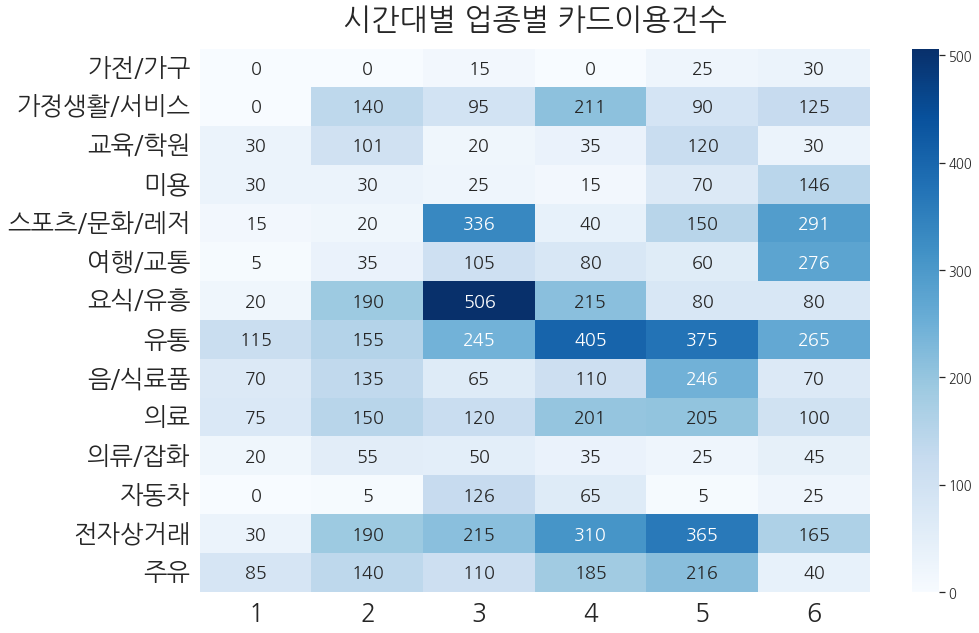

In [ ]:
plt.figure(figsize=(15,10))
plt.title('시간대별 업종별 카드이용건수',fontsize=30)
sns.heatmap(data4_pivot,annot=True,fmt='.0f',cmap='Blues')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel(None)
plt.ylabel('')
plt.show()

In [ ]:
data4['amt_corr']=data4['amt_corr'].divide(10000) #금액 단위를 만원으로 맞춰줍니다.

data4_pivot1=data4.pivot_table(index='class1',values='amt_corr'
                              ,columns='time',aggfunc=sum)
data4_pivot1=data4_pivot1.fillna(0)

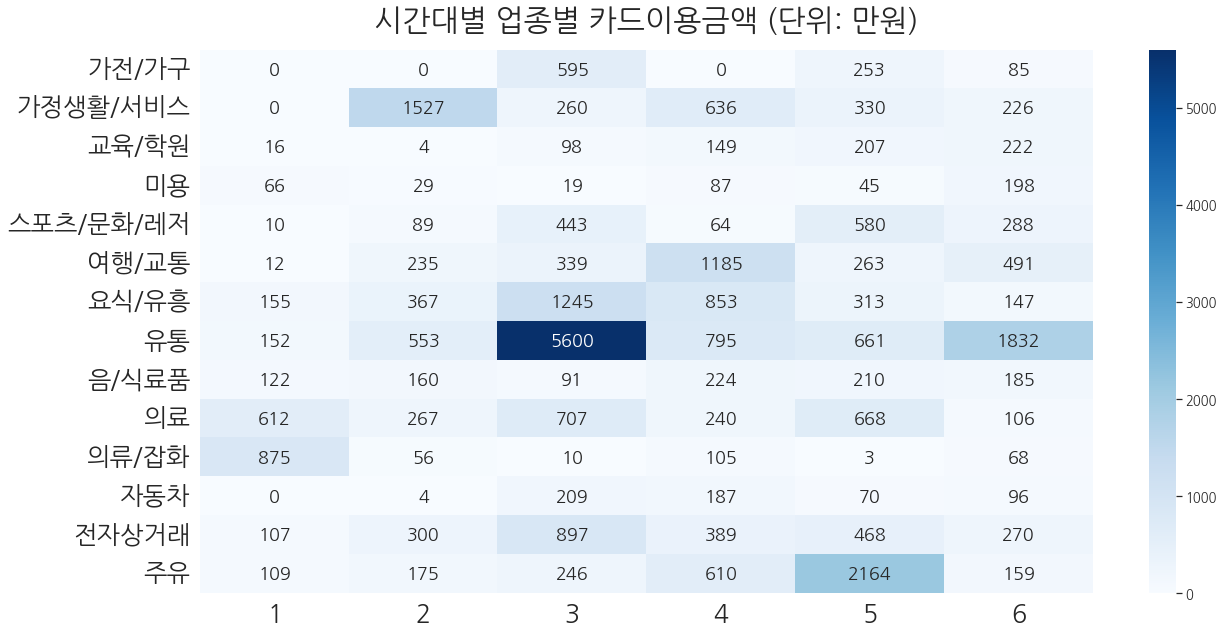

In [ ]:

plt.figure(figsize=(20,10))
plt.title('시간대별 업종별 카드이용금액 (단위: 만원)',fontsize=30)

sns.heatmap(data4_pivot1,annot=True,fmt='.0f',cmap='Blues')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel(None)
plt.ylabel('')
plt.show()

In [ ]:
data_dummy=agg_card_time.copy()


### 계절 칼럼 만들기
ymd는 int64로 저장돼 있고, YYYYMMDD 8자리로 돼있습니다.
10000으로 나눈 나머지의 천의 자리, 백의 자리는 월을 뜻합니다. 이를 이용해서 계절을 추출합니다.

In [ ]:
winter1 = (data_dummy['ymd']%10000 > 1200)
winter2 = (data_dummy['ymd']%10000 < 300)
spring = (data_dummy['ymd']%10000 > 300) & (data_dummy['ymd']%10000 < 600)
summer = (data_dummy['ymd']%10000 > 600) & (data_dummy['ymd']%10000 < 900)
fall = (data_dummy['ymd']%10000 > 900) & (data_dummy['ymd']%10000 < 1200)
data_dummy['season']=''
data_dummy.loc[winter1, 'season']='winter'
data_dummy.loc[winter2, 'season']='winter'
data_dummy.loc[spring, 'season']='spring'
data_dummy.loc[summer, 'season']='summer'
data_dummy.loc[fall, 'season']='fall'

In [ ]:
data_dummy.groupby('season')

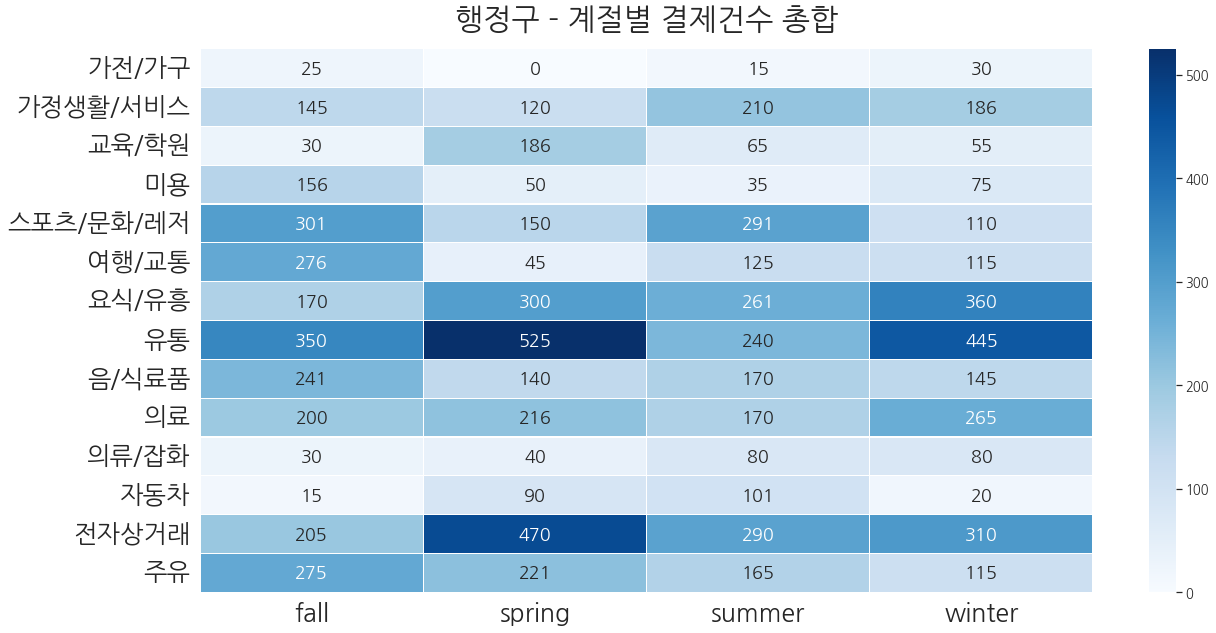

In [ ]:
fig = plt.figure(figsize=(20,10))
a =pd.crosstab(data_dummy['class1'],data_dummy['season'],values=data_dummy['usect_corr'],aggfunc=np.sum)
a.fillna(0.0,inplace=True)
a=a.astype(np.int)
sns.heatmap(a,annot =  True,fmt="d", linewidth=.1,cmap='Blues')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel(None)
plt.ylabel('')
plt.title('행정구 - 계절별 결제건수 총합', fontsize=30)
plt.show()

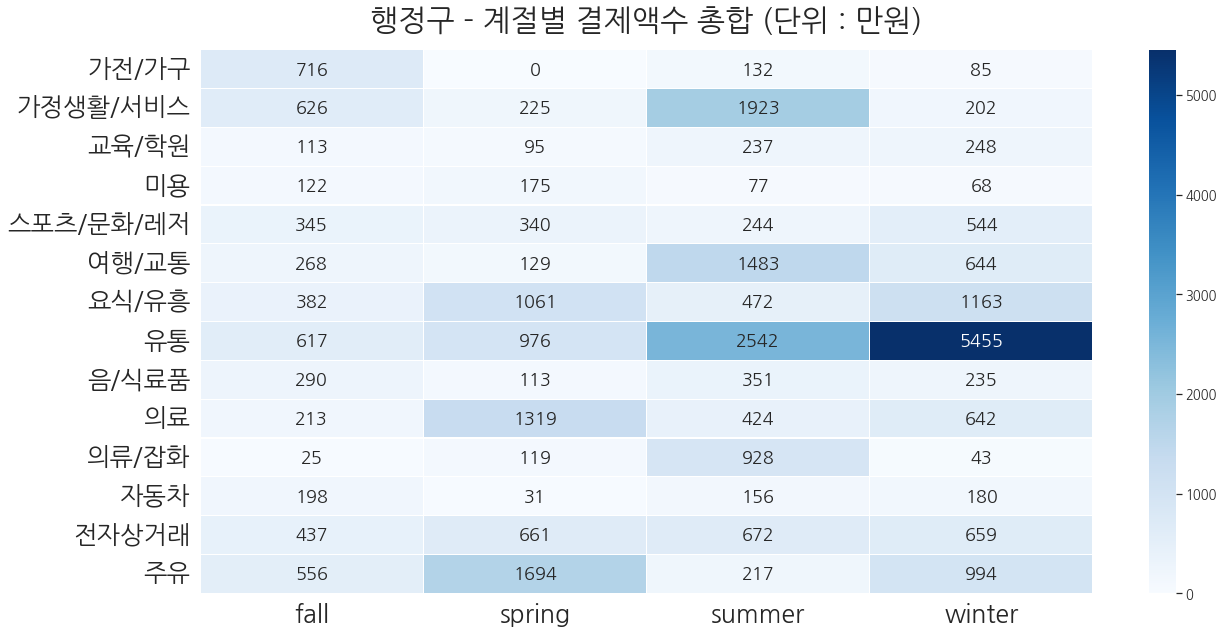

In [ ]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(20,10))
data_dummy['amt_corr'] = data_dummy['amt_corr'].divide(10000)
a =pd.crosstab(data_dummy['class1'],data_dummy['season'],values=data_dummy['amt_corr'],aggfunc=np.sum)
a.fillna(0.0,inplace=True)
a=a.astype(np.int)

b=sns.heatmap(a,annot =  True, fmt="d",linewidth=.1,cmap='Blues')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel(None)
plt.ylabel('')
plt.title('행정구 - 계절별 결제액수 총합 (단위 : 만원)', fontdict={'size':30})
plt.show()